In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_ed as util
import os
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Load data
data_file = os.path.join('..', 'data', 'er.csv')

# Arrival Estimation in Emergency Departments

### Context and Data

## Emergency Room @ Maggiore Hospital

**We will now consider a problem from the healthcare sector**

We will use a dataset for the "Maggiore" hospital in Bologna

<center><img src="assets/maggiore.jpg" width="65%"/></center>

* In particular, we will focus on predicting arrivals
* ...To the Emergency Department (Pronto Soccorso)

## A Look at the Dataset

**We will start as usual by having a look at the dataset**

In [3]:
data = util.load_ed_data(data_file)
data

,year,ID,Triage,TkCharge,Code,Outcome
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted
51238,2018,51239,2018-01-01 00:49:51,NaT,white,abandoned
51240,2018,51241,2018-01-01 01:00:40,NaT,green,abandoned
...,...,...,...,...,...,...
95665,2019,95666,2019-10-31 23:26:54,2019-10-31 23:41:13,yellow,admitted
95666,2019,95667,2019-10-31 23:46:43,2019-11-01 09:30:25,green,admitted
108622,2019,108623,2019-10-31 23:54:05,NaT,green,abandoned
95667,2019,95668,2019-10-31 23:55:32,2019-11-01 00:18:46,yellow,admitted


## A Look at the Dataset

**Dataset fields and there are four relevant fields:**

In [4]:
data.iloc[:2]

,year,ID,Triage,TkCharge,Code,Outcome
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted


* `Triage` is the arrival time of each patient
* `TKCharge` is the time when a patient starts the first visit
* `Code` refers to the estimated priority (white < green < yellow < red)
* `Outcome` discriminates some special conditions (people quitting, fast tracks)

We'll sort the rows by increasing triage time:

In [5]:
data.sort_values(by='Triage', inplace=True)

## Inter-Arrival Times

**Let's check empirically the distribution of the inter-arrival times**

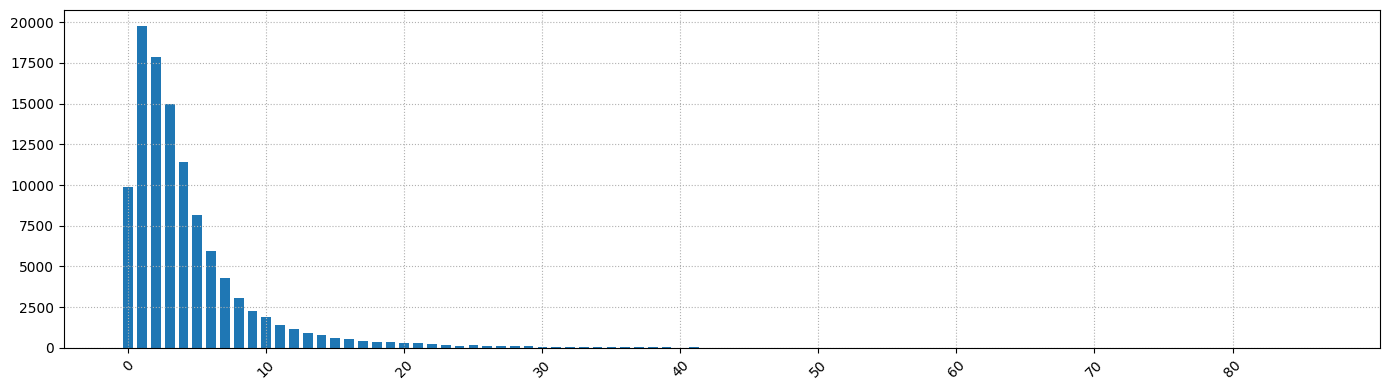

In [6]:
delta = data['Triage'].iloc[1:].round('2min') - data['Triage'].iloc[:-1].round('2min').values
tmp = delta.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
util.plot_bars(tmp, tick_gap=10, figsize=figsize)

* There is a number of very low inter-arrival times
* This is due to how triage is performed (bursts, rather than a steady flow)

## Waiting Time

**Here is the distribution of the waiting times**

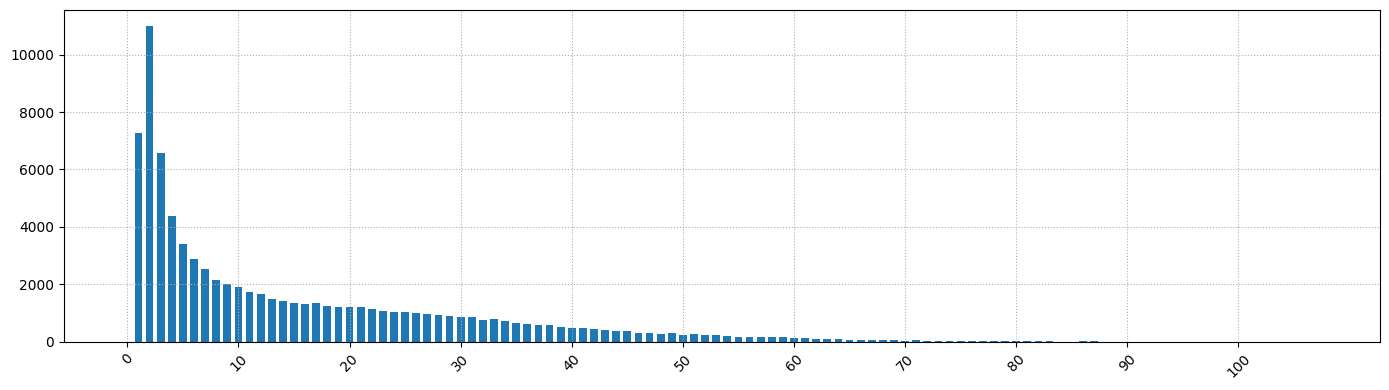

In [7]:
tmp = data[~data['TkCharge'].isnull()]
wait_time = tmp['TkCharge'].round('10min') - tmp['Triage'].round('10min')
tmp = wait_time.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
util.plot_bars(tmp, tick_gap=10, figsize=figsize)

* The distritbution is _heavy-tailed_ (large waiting times are quite relatively likely)

# Arrival Estimation in Emergency Departments

### Number of Arrivals

## Binning

**We will be interested in estimating the number of arrivals in a hour**

First, we use a one-hot encoding for the priority codes

In [8]:
codes = pd.get_dummies(data['Code'])
codes.set_index(data['Triage'], inplace=True)
codes.columns = codes.columns.to_list()
print(f'Number of examples: {len(codes)}')
codes.head()

Number of examples: 108625


,green,red,white,yellow
Triage,,,,
2018-01-01 00:17:33,True,False,False,False
2018-01-01 00:20:33,True,False,False,False
2018-01-01 00:47:59,False,False,True,False
2018-01-01 00:49:51,False,False,True,False
2018-01-01 01:00:40,True,False,False,False


## Resampling

**Then, we need to aggregate data with a specified frequency**

In [9]:
codes_b = codes.resample('H').sum()
print(f'Number of examples: {len(codes_b)}')
codes_b.head()

Number of examples: 16056


,green,red,white,yellow
Triage,,,,
2018-01-01 00:00:00,2,0,2,0
2018-01-01 01:00:00,7,1,1,1
2018-01-01 02:00:00,4,1,4,3
2018-01-01 03:00:00,7,0,1,1
2018-01-01 04:00:00,3,0,2,0


We count the arrivals in each hour, for each code

## Computing Totals

**Then we compute the total arrival counts**

In [10]:
cols = ['white', 'green', 'yellow', 'red']
codes_b['total'] = codes_b[cols].sum(axis=1)
codes_b

,green,red,white,yellow,total
Triage,,,,,
2018-01-01 00:00:00,2,0,2,0,4
2018-01-01 01:00:00,7,1,1,1,10
2018-01-01 02:00:00,4,1,4,3,12
2018-01-01 03:00:00,7,0,1,1,9
2018-01-01 04:00:00,3,0,2,0,5
...,...,...,...,...,...
2019-10-31 19:00:00,3,1,0,4,8
2019-10-31 20:00:00,9,0,2,0,11
2019-10-31 21:00:00,3,0,0,2,5


## Adding Time Information

**Finally, we add time information (for later convenience)**

In [11]:
codes_bt = codes_b.copy()
codes_bt['month'] = codes_bt.index.month
codes_bt['weekday'] = codes_bt.index.weekday
codes_bt['hour'] = codes_bt.index.hour
codes_bt

,green,red,white,yellow,total,month,weekday,hour
Triage,,,,,,,,
2018-01-01 00:00:00,2,0,2,0,4,1,0,0
2018-01-01 01:00:00,7,1,1,1,10,1,0,1
2018-01-01 02:00:00,4,1,4,3,12,1,0,2
2018-01-01 03:00:00,7,0,1,1,9,1,0,3
2018-01-01 04:00:00,3,0,2,0,5,1,0,4
...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,3,1,0,4,8,10,3,19
2019-10-31 20:00:00,9,0,2,0,11,10,3,20
2019-10-31 21:00:00,3,0,0,2,5,10,3,21


## Counts over Time

**Our resampled series can be plotted easily over time**

Let's see the total counts as an example:

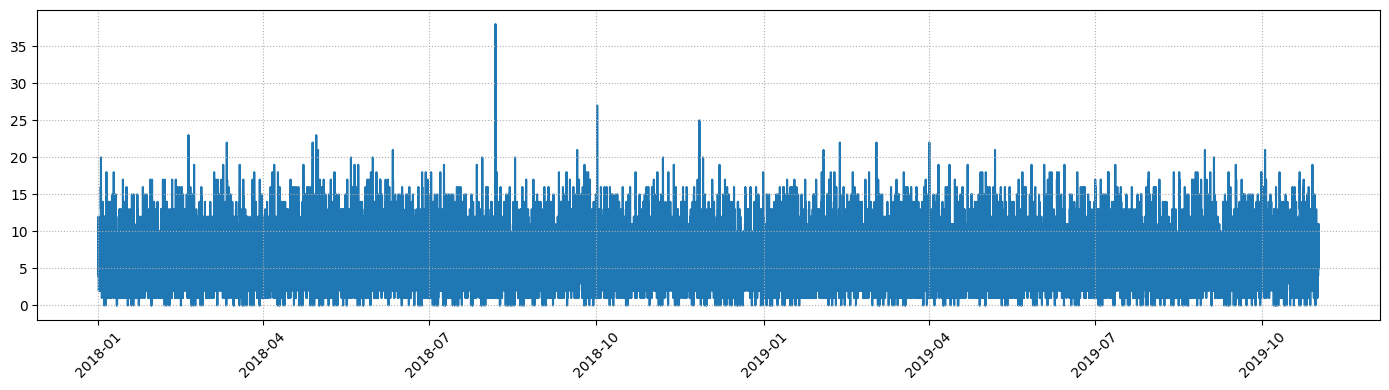

In [12]:
util.plot_series(codes_b['total'], figsize=figsize)

## Variability

**With our binned series, we can assess the count variability**

Let's check it over different months:

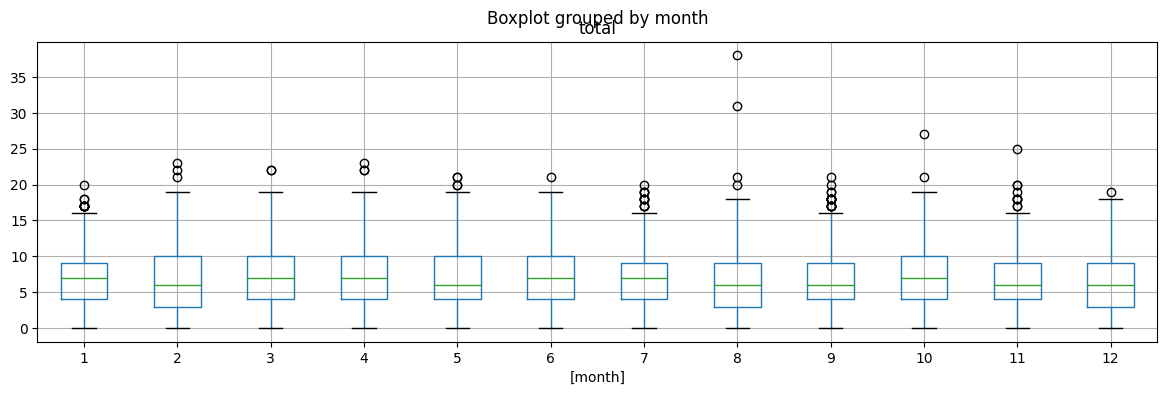

In [13]:
codes_bt[['month', 'total']].boxplot(by='month', figsize=figsize);

* The variability does not change much over different months

## Variability

**Here is the standard deviation over weekdays**

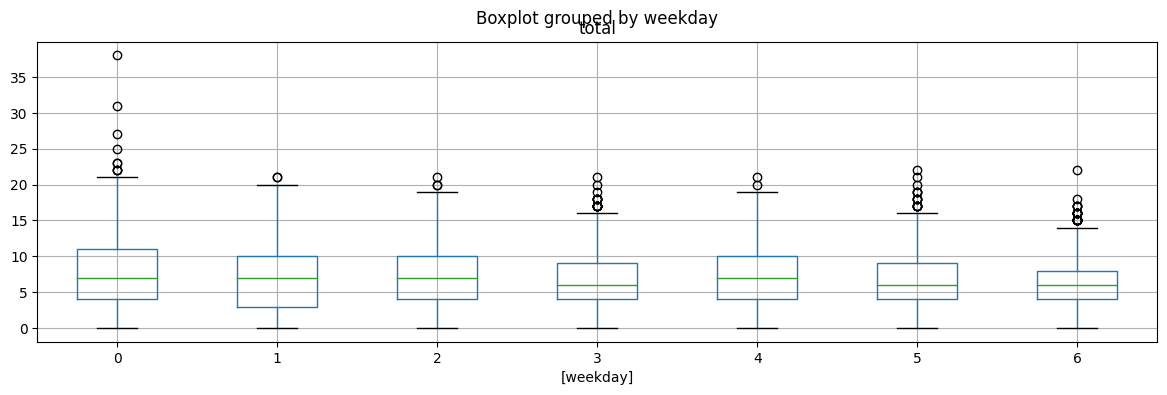

In [14]:
codes_bt[['weekday', 'total']].boxplot(by='weekday', figsize=figsize);

* There is a trend, but rather weak

## Variability

**...And finally over hours**

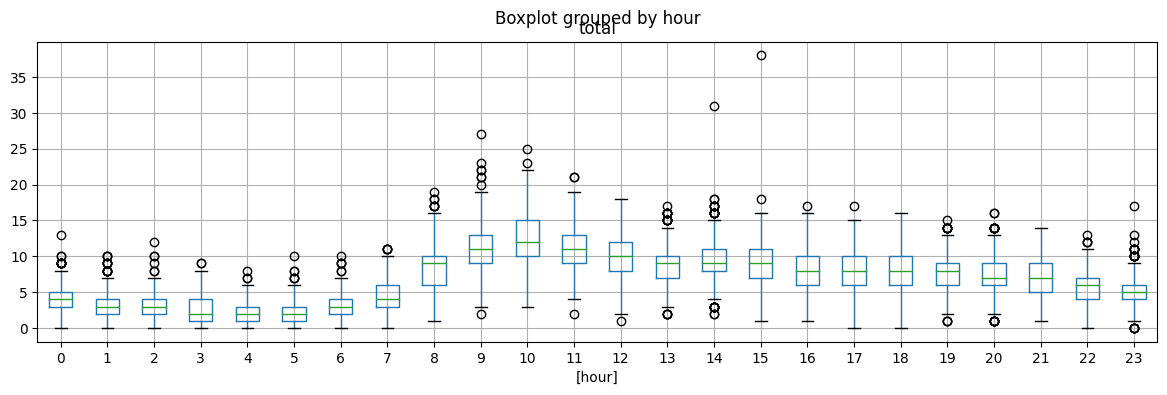

In [15]:
codes_bt[['hour', 'total']].boxplot(by='hour', figsize=figsize);

* Variance and mean seem to be quite correlated

# Arrival Estimation in Emergency Departments

### Estimating Stochastic Quantities

## Arrival Prediction

**We can now frame our arrival prediction problem**

We have some _input information_:

* Hour, day of the week, and month
* ...Plus possibly the observed arrivals in previous hours

We want to _predict the number of arrivals_ in the next interval

**Have we encountered similar tasks in other use cases?**

> **On the face of it, this is a _regression_ problem**<br>But there is a catch!

## Prediction and Randomness

**The number of arrivals is not subject to a lot of uncertainty!**

Let's check its values against the most informative input, i.e. the hour of the day

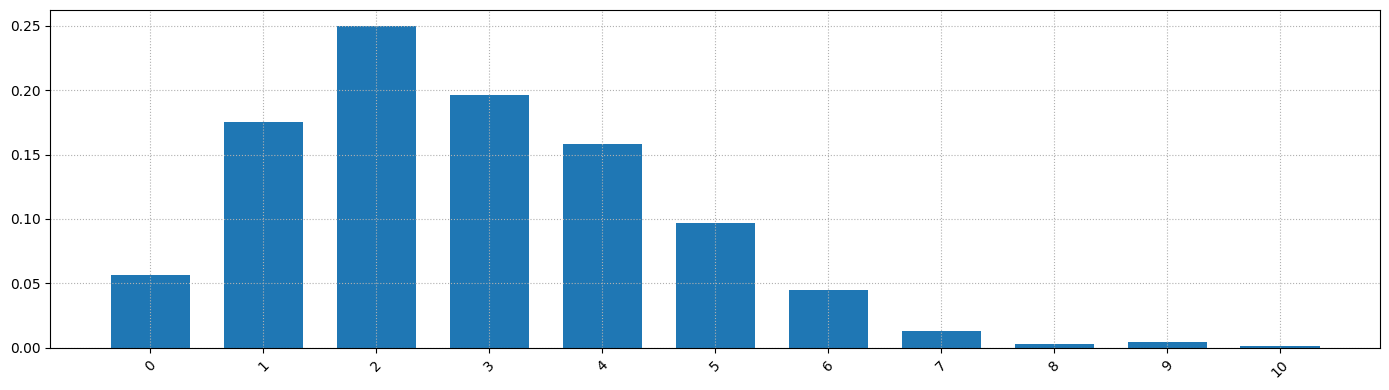

In [16]:
tmp = codes_b[codes_b.index.hour == 6]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
util.plot_bars(tmpv, figsize=figsize)

* There isn't a single, very likely value: the number of arrival is _stochastic_!

## Identifying the Distribution

**Instead of predicting a value, we can predict _the probability of every possible value_**

Formally, our goal is estimating a _conditional distribution_

$$
P(Y \mid X)
$$

* $X$ is the observable input information we choose to employ
* $Y$ is the number of arrivals in the next hour

**We can think of training a parameterized model on this purpose**

$$
\hat{f}(x; \theta) \simeq P(Y \mid X)
$$

* We will see one viable approach to achieve that
* ...Provided that we know the type of distribution we want to predict

## Poisson Distribution

**Many arrival process are well described by Poisson distributions**

The Poisson distribution is defined by a single parameter $\lambda$

$\lambda$ is the rate of occurrence of the events

* The distribution has a _discrete support_
* The Probability Mass Function is:
$$
p(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$
* Both the _mean_ and the _standard deviation_ have the same value (i.e. $\lambda$)

**The distribution is a good choice provided that the events we are counting are:**

* Independent
* Happening with a costant rate

## Fitted Poisson Distribution

**Let's try to fit a Poisson distribution over our target**

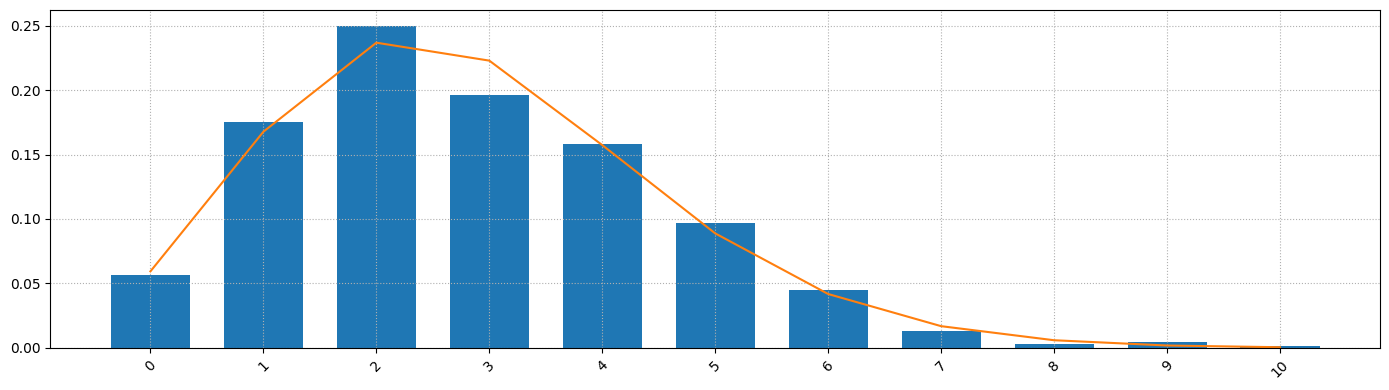

In [17]:
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

It's a very good match!

## Fitted Poisson Distribution

**Let's try for 8AM (closer to the peak)**

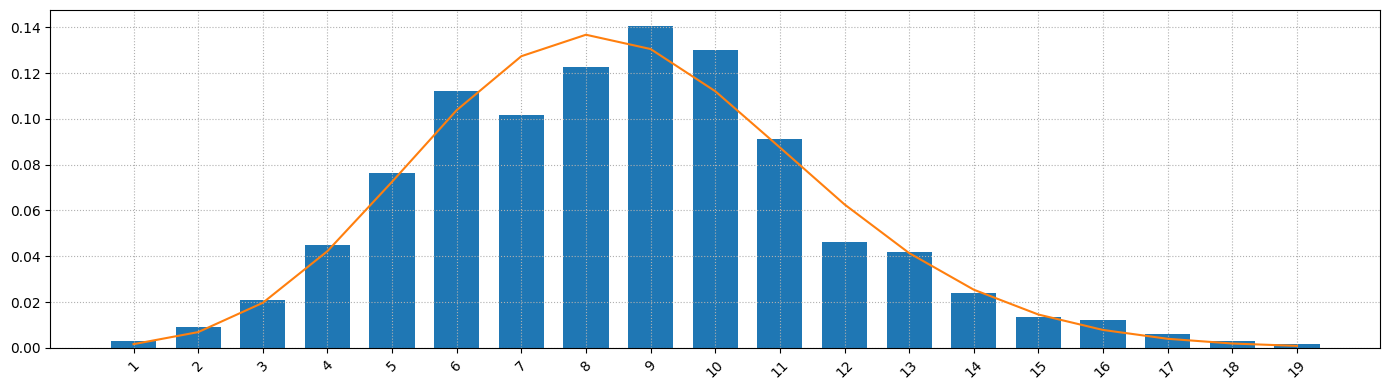

In [18]:
tmp = codes_b[codes_b.index.hour == 8]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

## Fitted Poisson Distribution

**...And finally for the peak itself (11am)**

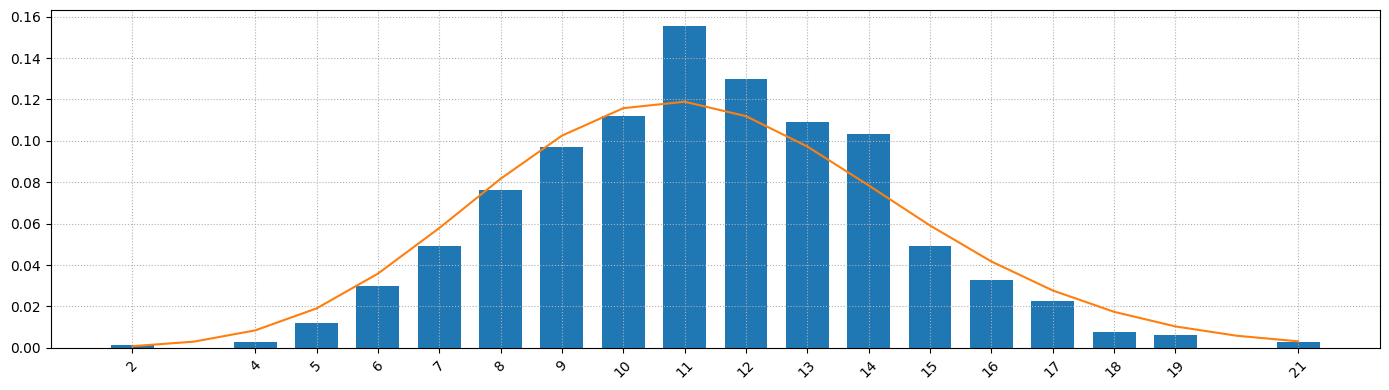

In [19]:
tmp = codes_b[codes_b.index.hour == 11]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

# Arrival Estimation in Emergency Departments

### Context and Data

## Learning and Estimator

> **How can we build an estimator for our problem?**

**We could build a table**

For example, we could compute average arrivals for every hour of the day

* These correspond to $\lambda$ for that hour, so we target the correct distribution
* ...But the approach has trouble scaling to multiple features

**We could train a regressor as usual**

For example a Linear Regressor or a Neural Network, with the classical MSE loss

* If we do this, it's easy to include multiple input features
* ...But we would be targeting the wrong type of distribution!

## Neuro-Probabilistic Models

**In practice there is an alternative**

Let's start by build a _probabilistic model_ of our phenomenon:

$$
y \sim \text{Pois}(\lambda(x))
$$

* The number arrivals in a 1-hour bin (i.e. $y$)
* ...Is _drawn from a Poisson distribution_ (parameterized with a rate)
* ...But _the rate is a function_ of known input, i.e. $\lambda(x)$

**Then we can approximate lambda using an estimator**, leading to:

$$
y \sim \text{Pois}(\lambda(x, \theta))
$$

* $\lambda(x, \theta)$ can be any model, with parameter vector $\lambda$

This is a _hybrid_ approach, combining statistics and ML

## Neuro-Probabilistic Models

**How do we train this kind of model?**

Just as usual, i.e. for (empirical) maximum log likelihood:

$$
\mathop{\text{argmin}}_\theta - \sum_{i=1}^m \log f(\hat{y}_i, \lambda(\hat{x}_i, \theta))
$$

* Where $f(\hat{y}_i, \lambda)$ is the probability of value $\hat{y}_i$ according to the distribution
* ...And $\lambda(\hat{x}_i, \theta)$ is the estimate rate for the input $\hat{x}_i$

**In detail, in our case we have:**

$$
\mathop{\text{argmin}}_\theta - \sum_{i=1}^m \log \frac{\lambda(\hat{x}_i, \theta)^{\hat{y}_i} e^{-\lambda(\hat{x}_i, \theta)}}{\hat{y}_i!}
$$

...Which is differentiable and _can be solved via gradient descent_!

## Building a Neuro-Probabilistic Model

**We can build this class of models by using custom loss functions**

...But it's easier to use a library such as [TensorFlow Probability](https://www.tensorflow.org/probability)

* TFP provides a layer the abstracts [a generic probability distribution](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda):

```python
tfp.layers.DistributionLambda(distribution_function, ...)
```
* And function (classes) to model [many statistical distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions), e.g.:
```python
tfp.distributions.Poisson(log_rate=None, ...)
```

**About the `DistributionLambda` layer**

* Its input is a symbolic tensor (like for any other layer)
* Its output is tensor of probability distribution _objects_
* ...Rather than a tensor of numbers

## Building a Neuro-Probabilistic Model

**The `util` module contains code to build our neuro-probabilistic model**

```python
def build_nn_poisson_model(input_shape, hidden, rate_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(rate=rate_guess * tf.math.exp(t))
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model
```

* An MLP architecture computes the `log_rate` tensor (corresponding to $\log \lambda(x)$)
* Using a log, we make sure the rate is _strictly positive_
* A `DistributionLambda` yield the output (a distribution object)

## Building a Neuro-Probabilistic Model

**The `util` module contains code to build our neuro-probabilistic model**

```python
def build_nn_poisson_model(input_shape, hidden, rate_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(rate=rate_guess * tf.math.exp(t))
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model
```

* The `DistributionLambda` layer is parameterized with a function
* The function (`lf` in this cse) constructs the distribution object
* ...Based on its input tensor (called `t` in the code)

## Building a Neuro-Probabilistic Model

**We need to be careful about _initial parameter estimates_**

```python
def build_nn_poisson_model(input_shape, hidden, rate_guess=1):
    ...
    lf = lambda t: tfp.distributions.Poisson(rate=rate_guess * tf.math.exp(t))
    ...
```

* Assuming standardized/normalized input, under default weight initialization
* ...The `log_rate` tensor will be initially close to 0
* Meaning out rate $\lambda$ would be initially close to $e^0 = 1$

**We need to make sure that this guess is _meaningful for our target_**

* In the code, this is achieve by scaling the rate
* ...With a guess that must be passed at model construction time

## Training a Neuro-Probabilistic Model

**Training the model requires to specify the loss function**

...Which in our case is the _negative log-likelihood_

* So, it turns out we do need a custom loss functions
* ...But with TFP this is easy to compute

**In particular, as loss function we _always_ use:**

```python
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
```

* The first parameter is the observed value (e.g. actual number of arrivals)
* The second is the distribution computed by the `DistributonLambda` layer
* ...Which provides the method `log_prob`

## Data Preparation

**Let's see the approach in practice**

We will start by preparing our data:

* As input we will use the field `weekday` in natural form
* ...And the field `hour` using a one-hot encoding

**Let's perform the encoding:**

In [20]:
np_data = pd.get_dummies(codes_bt, columns=['hour'], dtype='int32')
np_data.iloc[:2]

,green,red,white,yellow,total,month,weekday,hour_0,hour_1,hour_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Triage,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2,0,2,0,4,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 01:00:00,7,1,1,1,10,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation

**Now we can separate the training and test data**

In [21]:
sep = '2019-01-01'
np_tr = np_data[np_data.index < sep]
np_ts = np_data[np_data.index >= sep]

**...And then the input and output**

In [22]:
in_cols = [c for c in np_data.columns if c.startswith('hour')] + ['weekday']
out_col = 'total'

np_tr_in = np_tr[in_cols].copy()
np_tr_in['weekday'] = np_tr_in['weekday'] / 6
np_tr_out = np_tr[out_col].astype('float64')

np_ts_in = np_ts[in_cols].copy()
np_ts_in['weekday'] = np_ts_in['weekday'] / 6
np_ts_out = np_ts[out_col].astype('float64')

## Data Preparation

**The input data need to be standardized/normalized as usual**

In our case, we do this only for weekday (the hours are already $\in \{0, 1\}$)

```python
np_tr_in['weekday'] = np_tr_in['weekday'] / 6
```

**The output does not require standarization**

...But we need to represent it using floating point numbers

```python
np_tr_out = np_tr[out_col].astype('float64')
```

* This is an implementation requirement for TensorFlow

## Building the Model

**We can now build the Neuro-Probabilistic model**

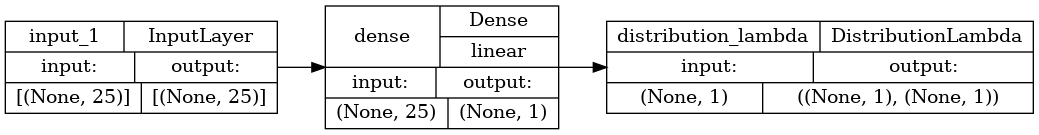

In [23]:
nnp = util.build_nn_poisson_model(input_shape=len(in_cols), hidden=[], rate_guess=np_tr_out.mean())
util.plot_nn_model(nnp)

As a rate guess we use the average over the training set

* This is easy to compute
* ...And will provide a better starting point for gradient descent

## Training the Model

**We can train the model (mostly) as usual**

...Except that we need to use the mentioned custom loss function

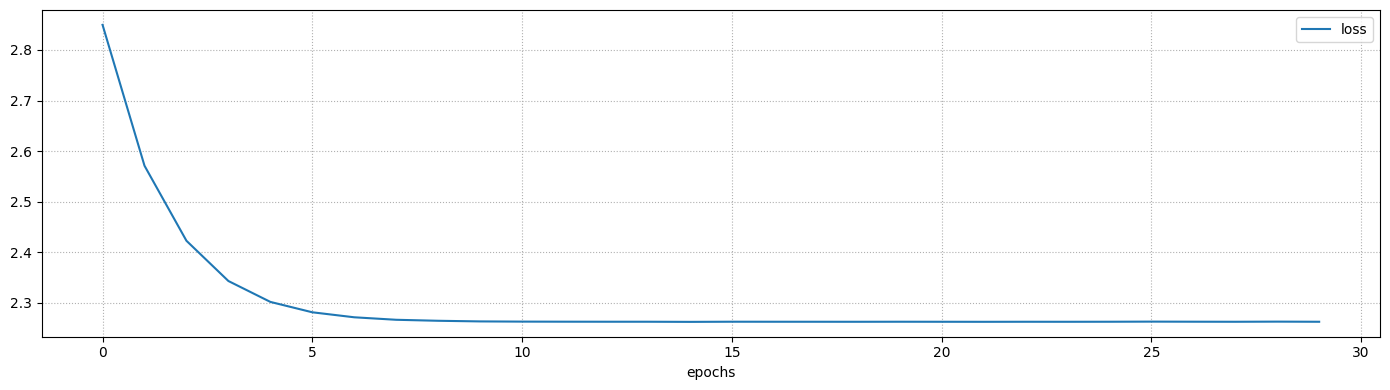

Final loss: 2.2628 (training)


In [24]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnp = util.build_nn_poisson_model(input_shape=len(in_cols), hidden=[], rate_guess=np_tr_out.mean())
history = util.train_nn_model(nnp, np_tr_in, np_tr_out, loss=negloglikelihood, validation_split=0.0, batch_size=32, epochs=30)
util.plot_training_history(history, figsize=figsize)

## Predictions

**When we call the `predict` method on the model we obtain _samples_**

This means that the result of `predict` is _stochastic_

In [25]:
print(str(nnp.predict(np_tr_in, verbose=0)[:3]).replace('\n', ' '))
print(str(nnp.predict(np_tr_in, verbose=0)[:3]).replace('\n', ' '))

[[2.]  [3.]  [2.]]
[[3.]  [3.]  [5.]]


**We can obtain the distribution object by simply _calling the model_**

In [26]:
nnp(np_tr_in.values)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[8760, 1] event_shape=[] dtype=float32>

* Then we can call _methods over the distribution objects_
* ...To obtain means, standard deviations, and any other relevant statistics

## Evaluation

**Using the predict means, let's check the quality of our results**

R2: 0.60
MAE: 1.93


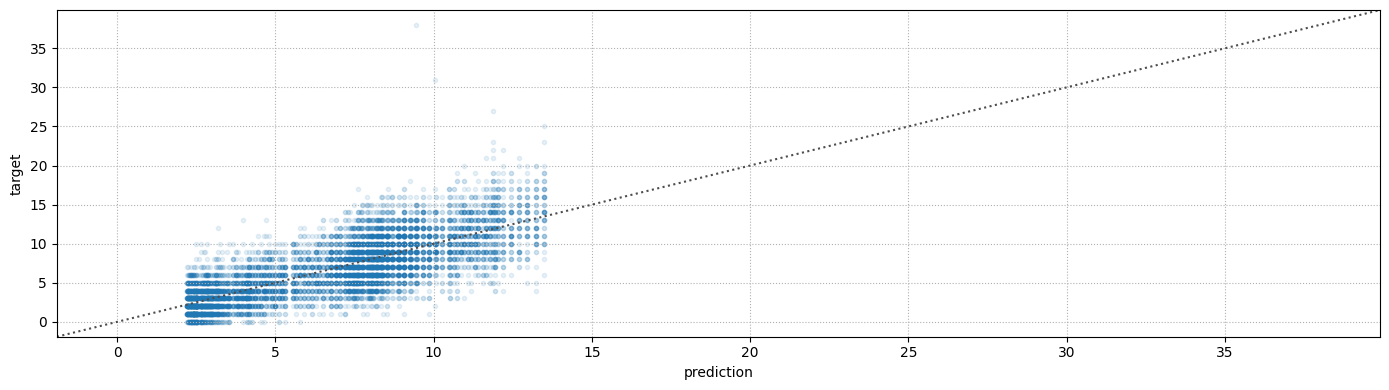

In [27]:
tr_pred = nnp(np_tr_in.values).mean().numpy().ravel()
util.plot_pred_scatter(np_tr_out, tr_pred, figsize=figsize)

* This is a _stochastic_ process, making this $R^2$ value _very good_
* When the stochasticity is too high, using the $R^2$ _might not even be viable_

## Evaluation

**Let's repeat the exercise on the test set**

R2: 0.60
MAE: 1.94


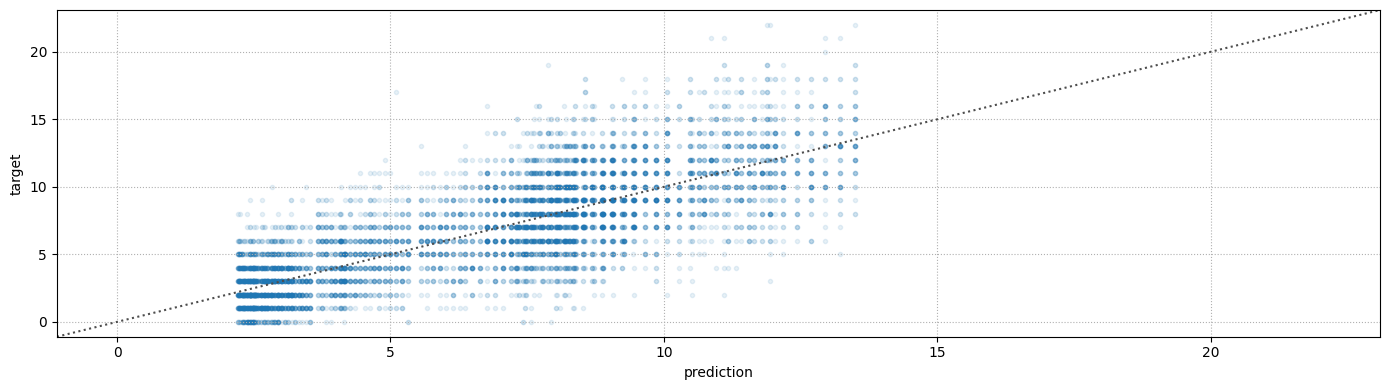

In [28]:
ts_pred = nnp(np_ts_in.values).mean().numpy().ravel()
util.plot_pred_scatter(np_ts_out, ts_pred, figsize=figsize)

* No overfitting, which is again very good

## Confidence Intervals

**Since our output is a distribution, we have access to _all sort of statistics_**

Here we will simply show the mean and stdev over one week of data:

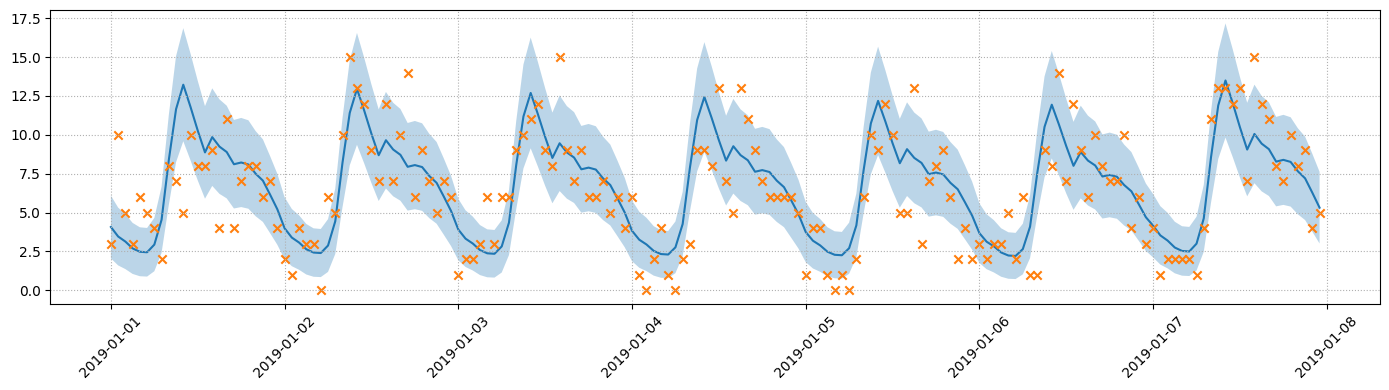

In [29]:
ts_pred_std = nnp(np_ts_in.values).stddev().numpy().ravel()
util.plot_series(pd.Series(index=np_ts_in.index[:24*7], data=ts_pred[:24*7]), std=pd.Series(index=np_ts_in.index[:24*7], data=ts_pred_std[:24*7]), figsize=figsize)
plt.scatter(np_ts_in.index[:24*7], np_ts_out[:24*7], marker='x');